# 영균의 EDA 및 예측 방향성
- 행정동별로 구역을 나누는 것도 방법이겠지만, 해당 정보는 위도와 경도 정보에 담겨 있다고 보고 예측을 진행해 보는 것도 좋을 것 같다. (구역을 나누는 방법과의 차이를 비교해봐도 좋을듯)

- deposit 값에 대해서는 이상치를 제거해야 한다고 생각하는 편. 다른 피처는 생각해 봐야겠다.

- contract_type에서 모른다 라고 응답한 값은 이상치로 보는 것이 좋겠다.

- 트리에서 xgb나 lgb는 많이들 할테니까 catboost 위주로 할 것이다.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path: str = "../../data/"
train_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv"))
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))
interest_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "interestRate.csv"))
park_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "parkInfo.csv"))
school_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "schoolinfo.csv"))
subway_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "subwayInfo.csv"))

In [3]:
subway_df

,latitude,longitude
0,37.759380,127.042292
1,37.541021,126.971300
2,37.529849,126.964561
3,37.514219,126.942454
4,37.513342,126.926382
...,...,...
695,37.378384,126.645168
696,37.386007,126.639484
697,37.393054,126.634729
698,37.399907,126.630347


In [3]:
train_data.drop("index", axis=1, inplace=True)
test_data.drop("index", axis=1, inplace=True)
train_data.head(10)

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0
5,84.9342,201904,26,2,13,2016,36.965423,127.048779,3,20000.0
6,39.2700,201905,7,2,3,1990,36.957089,127.047449,29,4000.0
7,84.9342,201905,9,2,3,2016,36.965423,127.048779,3,20000.0
8,84.9610,201905,25,2,3,2016,36.965423,127.048779,3,20500.0
9,84.9182,201905,25,2,13,2016,36.965423,127.048779,3,19000.0


In [4]:
from scipy.spatial import cKDTree

def find_closest_distance_kdtree(train_data, loc_df):
    train_coords = train_data[['latitude', 'longitude']].values
    park_coords = loc_df[['latitude', 'longitude']].values
    tree = cKDTree(park_coords)
    distances, _ = tree.query(train_coords)
    return distances

train_data["school_distance"] = find_closest_distance_kdtree(train_data, school_df)
train_data["park_distance"] = find_closest_distance_kdtree(train_data, park_df)
train_data["subway_distance"] = find_closest_distance_kdtree(train_data, subway_df)
test_data["school_distance"] = find_closest_distance_kdtree(test_data, school_df)
test_data["park_distance"] = find_closest_distance_kdtree(test_data, park_df)
test_data["subway_distance"] = find_closest_distance_kdtree(test_data, subway_df)

In [5]:
train_data = train_data.merge(interest_df, left_on='contract_year_month', right_on='year_month', how='left')
train_data.drop("year_month", axis=1, inplace=True)

In [6]:
test_data = test_data.merge(interest_df, left_on='contract_year_month', right_on='year_month', how='left')
test_data.drop("year_month", axis=1, inplace=True)

In [7]:
train_data["contract_year"] = train_data["contract_year_month"] // 100
train_data["contract_month"] = train_data["contract_year_month"] % 100
train_data.drop("contract_year_month", axis=1, inplace=True)
train_data

,area_m2,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,school_distance,park_distance,subway_distance,interest_rate,contract_year,contract_month
0,84.9981,25,2,9,2019,37.054314,127.045216,0,17000.0,0.001558,0.004779,0.007910,1.78,2019,6
1,84.9981,26,2,20,2019,37.054314,127.045216,1,23000.0,0.001558,0.004779,0.007910,1.26,2020,3
2,84.9981,28,2,8,2019,37.054314,127.045216,1,23000.0,0.001558,0.004779,0.007910,1.26,2020,3
3,59.3400,15,2,1,1986,36.964647,127.055847,33,5000.0,0.002046,0.001706,0.039234,1.68,2019,7
4,59.8100,12,2,6,1995,36.972390,127.084514,24,1800.0,0.015370,0.004277,0.018347,1.85,2019,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,114.8126,25,0,5,2010,37.528394,126.659398,13,39000.0,0.002454,0.004512,0.016569,4.00,2023,11
1801224,101.9088,28,0,6,2010,37.528394,126.659398,13,38000.0,0.002454,0.004512,0.016569,4.00,2023,11
1801225,114.7900,3,0,19,2010,37.528394,126.659398,13,37000.0,0.002454,0.004512,0.016569,3.84,2023,12
1801226,101.9088,4,1,15,2010,37.528394,126.659398,13,34400.0,0.002454,0.004512,0.016569,3.84,2023,12


In [8]:
test_data["contract_year"] = test_data["contract_year_month"] // 100
test_data["contract_month"] = test_data["contract_year_month"] % 100
test_data.drop("contract_year_month", axis=1, inplace=True)
test_data

,area_m2,contract_day,contract_type,floor,built_year,latitude,longitude,age,school_distance,park_distance,subway_distance,interest_rate,contract_year,contract_month
0,84.9610,12,1,14,2016,36.965423,127.048779,8,0.008568,0.003194,0.044314,3.54,2024,4
1,59.9000,13,0,4,1997,36.963105,127.040678,27,0.016303,0.001387,0.052359,3.54,2024,4
2,39.2700,29,0,5,1990,36.957089,127.047449,34,0.007719,0.002467,0.050533,3.54,2024,4
3,39.2700,3,0,1,1990,36.957089,127.047449,34,0.007719,0.002467,0.050533,3.56,2024,5
4,46.9800,2,0,4,1990,36.957089,127.047449,34,0.007719,0.002467,0.050533,NaN,2024,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150167,115.5101,27,0,17,2010,37.528394,126.659398,14,0.002454,0.004512,0.016569,3.62,2024,2
150168,142.8738,2,0,4,2010,37.528394,126.659398,14,0.002454,0.004512,0.016569,3.59,2024,3
150169,142.8738,16,1,13,2010,37.528394,126.659398,14,0.002454,0.004512,0.016569,3.59,2024,3
150170,114.9285,22,1,2,2010,37.528394,126.659398,14,0.002454,0.004512,0.016569,3.59,2024,3


In [14]:
pd.set_option("display.float_format", "{:.2f}".format)
max_idx = np.argmax(train_data["deposit"])
train_data.loc[max_idx, :]

area_m2               273.96
contract_day           13.00
contract_type           0.00
floor                  18.00
built_year           2020.00
latitude               37.53
longitude             127.05
age                     2.00
deposit           1100000.00
school_distance         0.01
park_distance           0.00
subway_distance         0.01
interest_rate           3.98
contract_year        2022.00
contract_month         10.00
Name: 1406833, dtype: float64

In [17]:
from geopy.distance import great_circle

def add_distance_column(df, target_location):
    """
    주어진 DataFrame에 특정 지점에서의 거리 열을 추가합니다.
    
    :param df: 위도와 경도가 포함된 DataFrame
    :param target_location: (위도, 경도) 튜플
    :return: 거리 열이 추가된 DataFrame
    """
    # 타겟 위치를 numpy 배열로 변환
    target_lat, target_lon = target_location

    # 위도와 경도를 numpy 배열로 변환
    latitudes = df['latitude'].to_numpy()
    longitudes = df['longitude'].to_numpy()

    # 거리 계산 (벡터화)
    distances = np.array([
        great_circle((lat, lon), target_location).kilometers
        for lat, lon in zip(latitudes, longitudes)
    ])

    # 거리 열 추가
    df['distance_km'] = distances
    return df

max_lat, max_long = train_data.loc[max_idx, ["latitude", "longitude"]]
train_data = add_distance_column(train_data, (max_lat, max_long))
test_data = add_distance_column(test_data, (max_lat, max_long))
train_data

,area_m2,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,school_distance,park_distance,subway_distance,interest_rate,contract_year,contract_month,distance_km
0,85.00,25,2,9,2019,37.05,127.05,0,17000.00,0.00,0.00,0.01,1.78,2019,6,52.45
1,85.00,26,2,20,2019,37.05,127.05,1,23000.00,0.00,0.00,0.01,1.26,2020,3,52.45
2,85.00,28,2,8,2019,37.05,127.05,1,23000.00,0.00,0.00,0.01,1.26,2020,3,52.45
3,59.34,15,2,1,1986,36.96,127.06,33,5000.00,0.00,0.00,0.04,1.68,2019,7,62.41
4,59.81,12,2,6,1995,36.97,127.08,24,1800.00,0.02,0.00,0.02,1.85,2019,4,61.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,114.81,25,0,5,2010,37.53,126.66,13,39000.00,0.00,0.00,0.02,4.00,2023,11,34.82
1801224,101.91,28,0,6,2010,37.53,126.66,13,38000.00,0.00,0.00,0.02,4.00,2023,11,34.82
1801225,114.79,3,0,19,2010,37.53,126.66,13,37000.00,0.00,0.00,0.02,3.84,2023,12,34.82
1801226,101.91,4,1,15,2010,37.53,126.66,13,34400.00,0.00,0.00,0.02,3.84,2023,12,34.82


<Axes: xlabel='distance_km', ylabel='Count'>

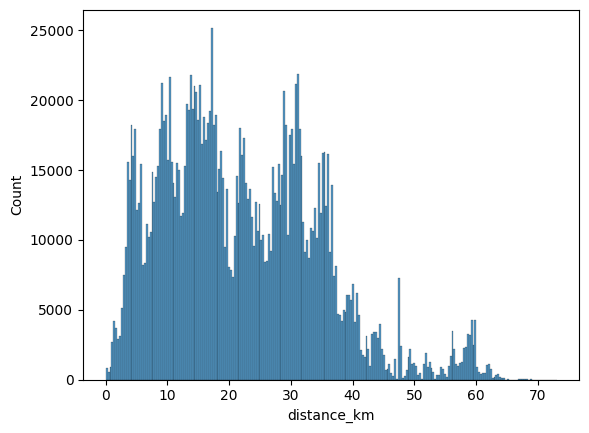

In [18]:
sns.histplot(data=train_data, x="distance_km")

# EDA

## Scatterplot

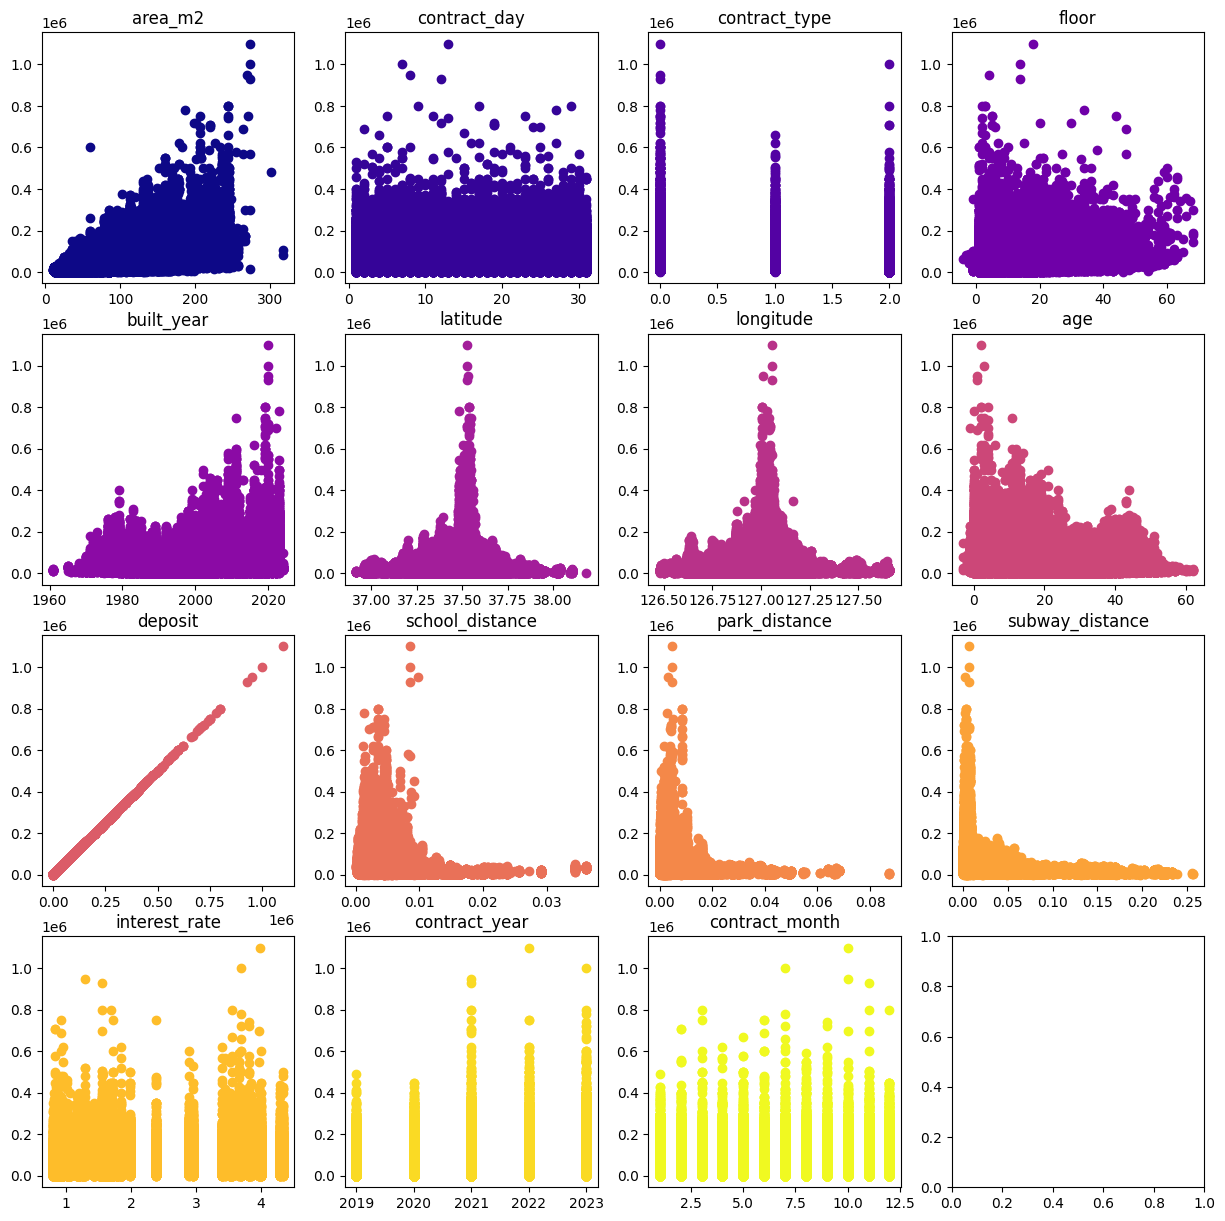

In [61]:
import matplotlib.cm as cm

colors = cm.plasma(np.linspace(0, 1, 15))

fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for i, feature in enumerate(train_data.columns):
    axs[i//4, i%4].scatter(data=train_data, x=feature, y="deposit", color=colors[i])
    axs[i//4, i%4].set_title(feature)

- 계약 유형은 갱신이 약간 싼 것으로 보이는데, 모름 응답이 생각보다 많아서 어찌해야 할지 모르겠네...

## Histplot

### 계약 연월일 분포

<Axes: xlabel='contract_year', ylabel='Count'>

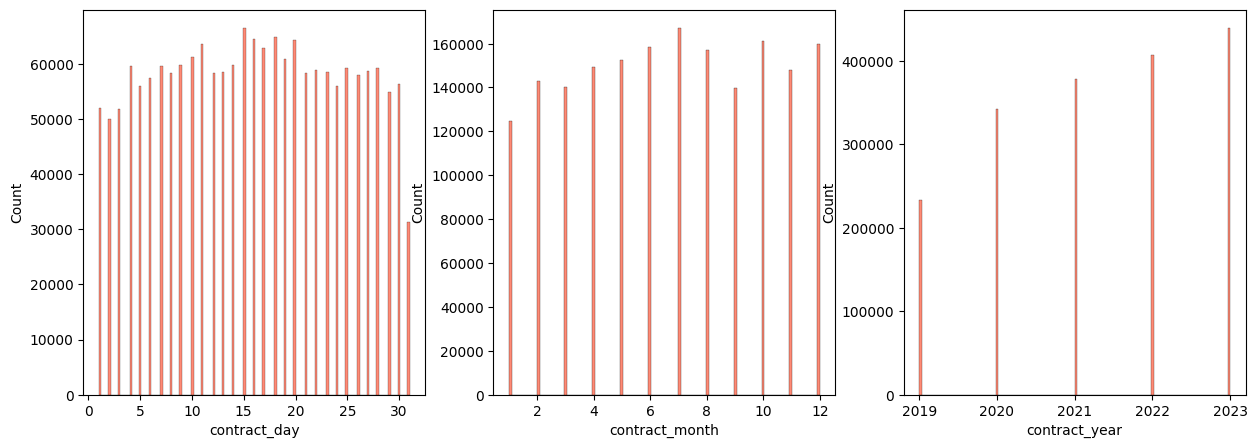

In [27]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=train_data, x="contract_day", color="tomato", ax=axs[0])
sns.histplot(data=train_data, x="contract_month", color="tomato", ax=axs[1])
sns.histplot(data=train_data, x="contract_year", color="tomato", ax=axs[2])

### 면적 분포

<Axes: xlabel='area_m2', ylabel='Count'>

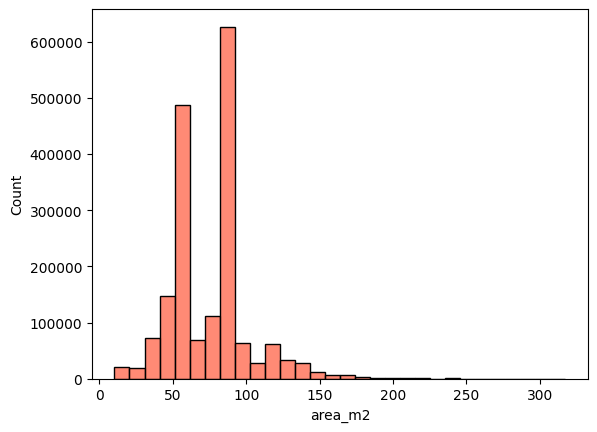

In [40]:
sns.histplot(data=train_data, x="area_m2", color="tomato", bins=30)

### 층수 분포

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


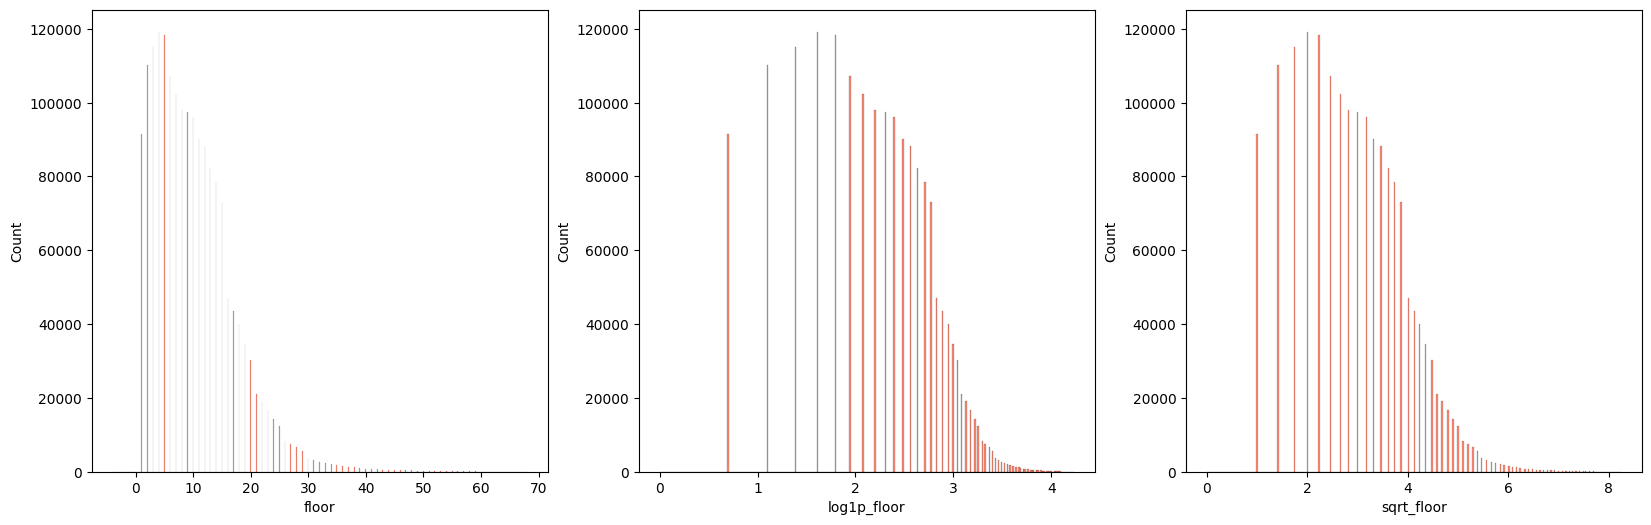

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(data=train_data, x="floor", color="tomato", ax=axs[0])
log1p_floor = np.log1p(train_data["floor"])
sns.histplot(data=log1p_floor, color="tomato", ax=axs[1])
axs[1].set_xlabel("log1p_floor")
sqrt_floor = np.sqrt(train_data["floor"])
sns.histplot(data=sqrt_floor, color="tomato", ax=axs[2])
axs[2].set_xlabel("sqrt_floor")

plt.show()

In [38]:
log1p_floor.isnull().sum(), train_data.loc[train_data["floor"] < -1, "floor"].shape[0]

(10, 10)

### 건축연도 분포

<Axes: xlabel='built_year', ylabel='Count'>

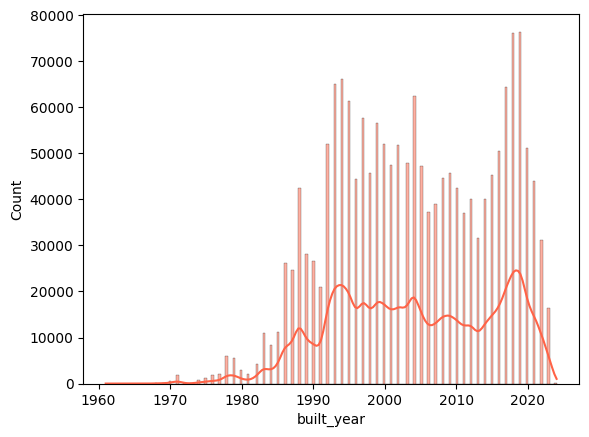

In [44]:
sns.histplot(data=train_data, x="built_year", color="tomato", kde=True)

### 위도, 경도 분포

<Axes: xlabel='latitude', ylabel='Count'>

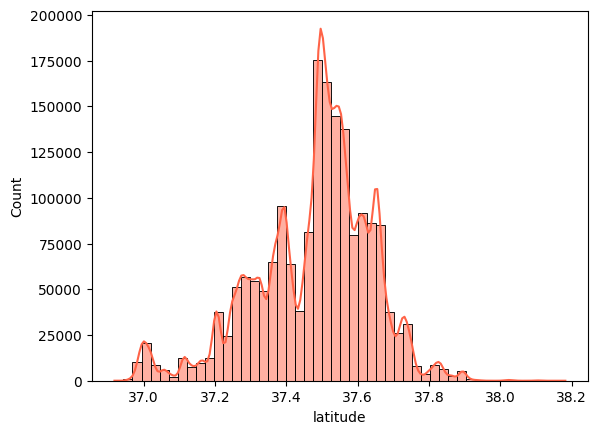

In [45]:
sns.histplot(data=train_data, x="latitude", color="tomato", kde=True, bins=50)

<Axes: xlabel='longitude', ylabel='Count'>

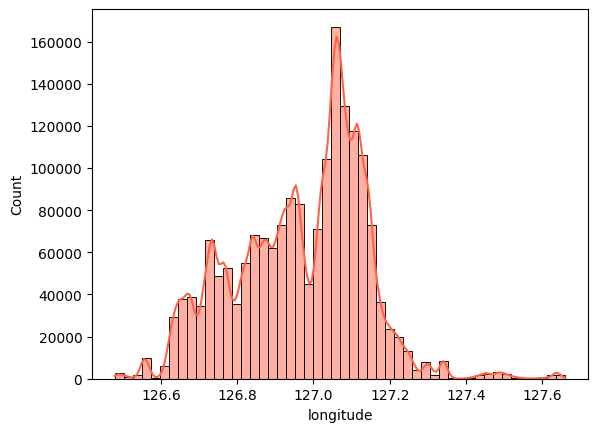

In [46]:
sns.histplot(data=train_data, x="longitude", color="tomato", kde=True, bins=50)

### 건물 연식 분포

<Axes: xlabel='age', ylabel='Count'>

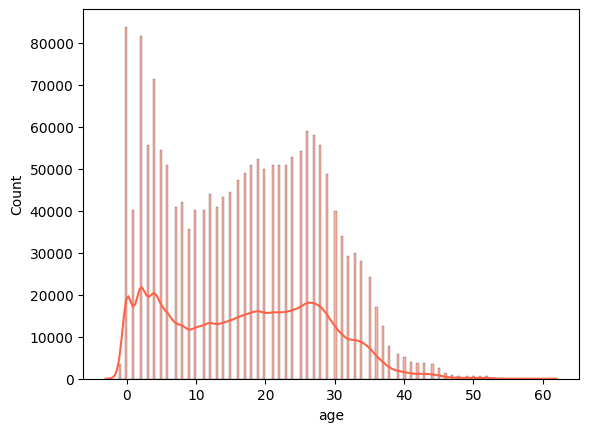

In [58]:
sns.histplot(data=train_data, x="age", color="tomato", kde=True)

### 전세 실거래가 분포

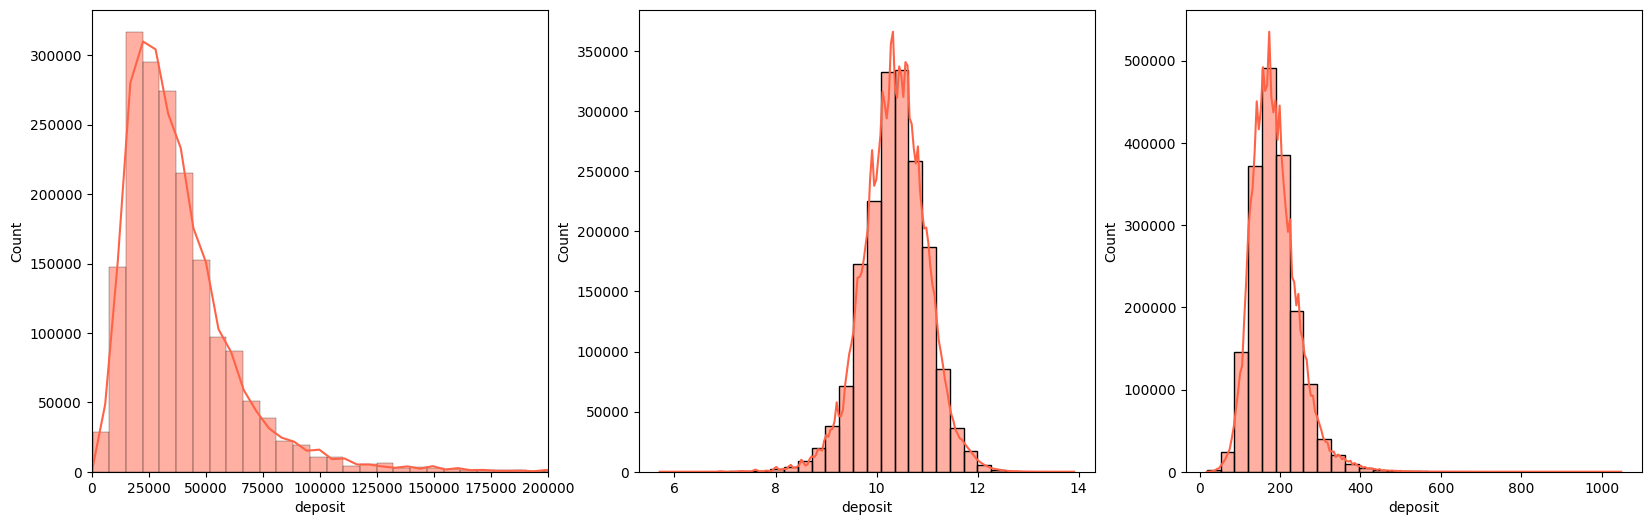

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(data=train_data, x="deposit", color="tomato", kde=True, bins=150, ax=axs[0])
axs[0].set_xlim(0, 200000)

log1p_deposit = np.log1p(train_data["deposit"])
sns.histplot(data=log1p_deposit, color="tomato", kde=True, bins=30, ax=axs[1])

sqrt_deposit = np.sqrt(train_data["deposit"])
sns.histplot(data=sqrt_deposit, color="tomato", kde=True, bins=30, ax=axs[2])

plt.show()

### 학교, 공원, 지하철역 최단거리 분포

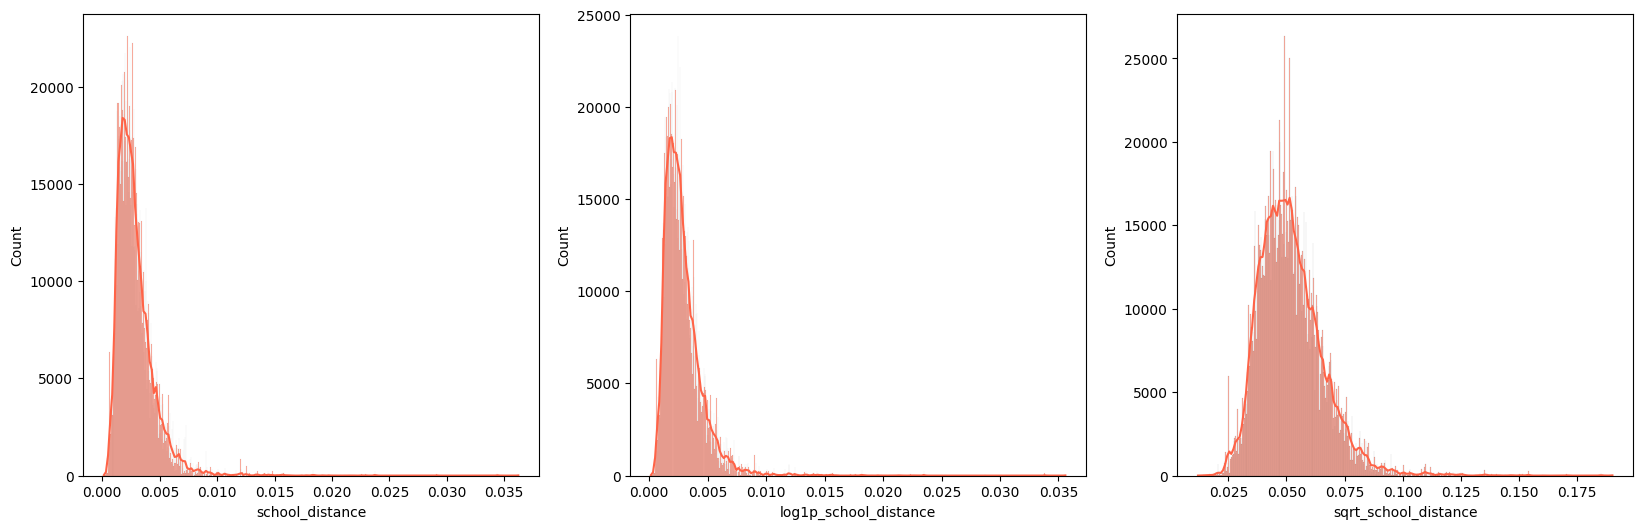

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(data=train_data, x="school_distance", color="tomato", kde=True, ax=axs[0])
log1p_school = np.log1p(train_data["school_distance"])
sns.histplot(data=log1p_school, color="tomato", kde=True, ax=axs[1])
axs[1].set_xlabel("log1p_school_distance")
sqrt_school = np.sqrt(train_data["school_distance"])
sns.histplot(data=sqrt_school, color="tomato", kde=True, ax=axs[2])
axs[2].set_xlabel("sqrt_school_distance")

plt.show()

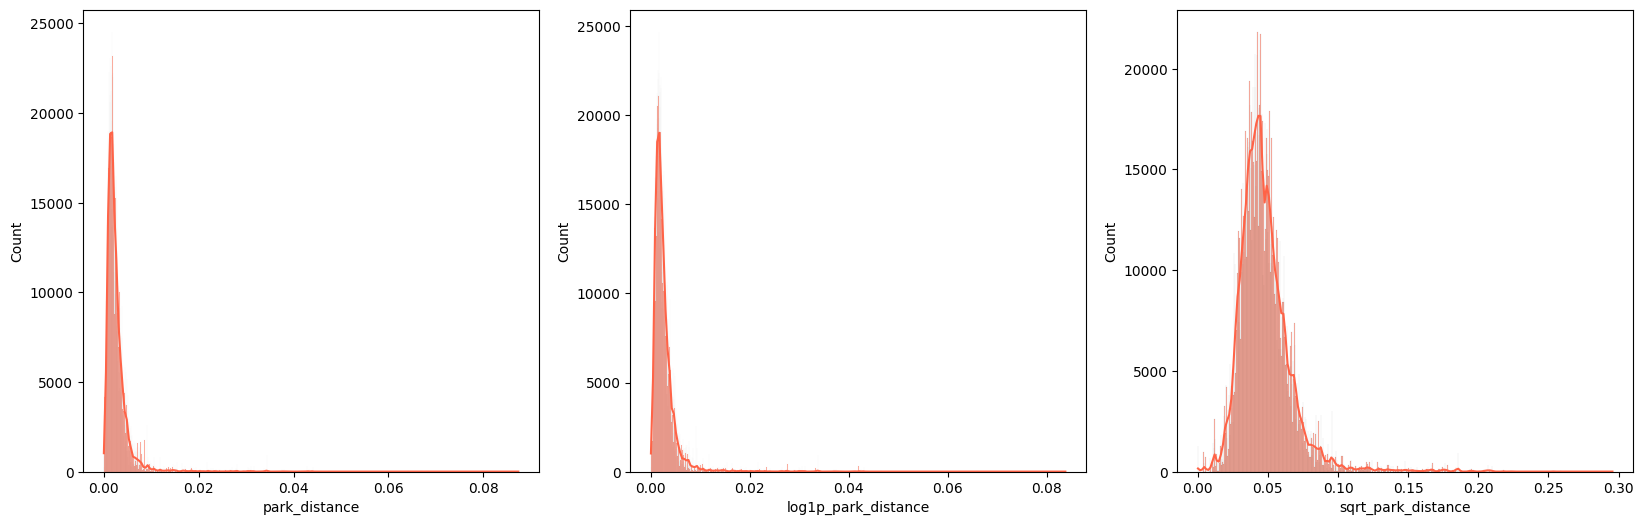

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(data=train_data, x="park_distance", color="tomato", kde=True, ax=axs[0])
log1p_school = np.log1p(train_data["park_distance"])
sns.histplot(data=log1p_school, color="tomato", kde=True, ax=axs[1])
axs[1].set_xlabel("log1p_park_distance")
sqrt_school = np.sqrt(train_data["park_distance"])
sns.histplot(data=sqrt_school, color="tomato", kde=True, ax=axs[2])
axs[2].set_xlabel("sqrt_park_distance")

plt.show()

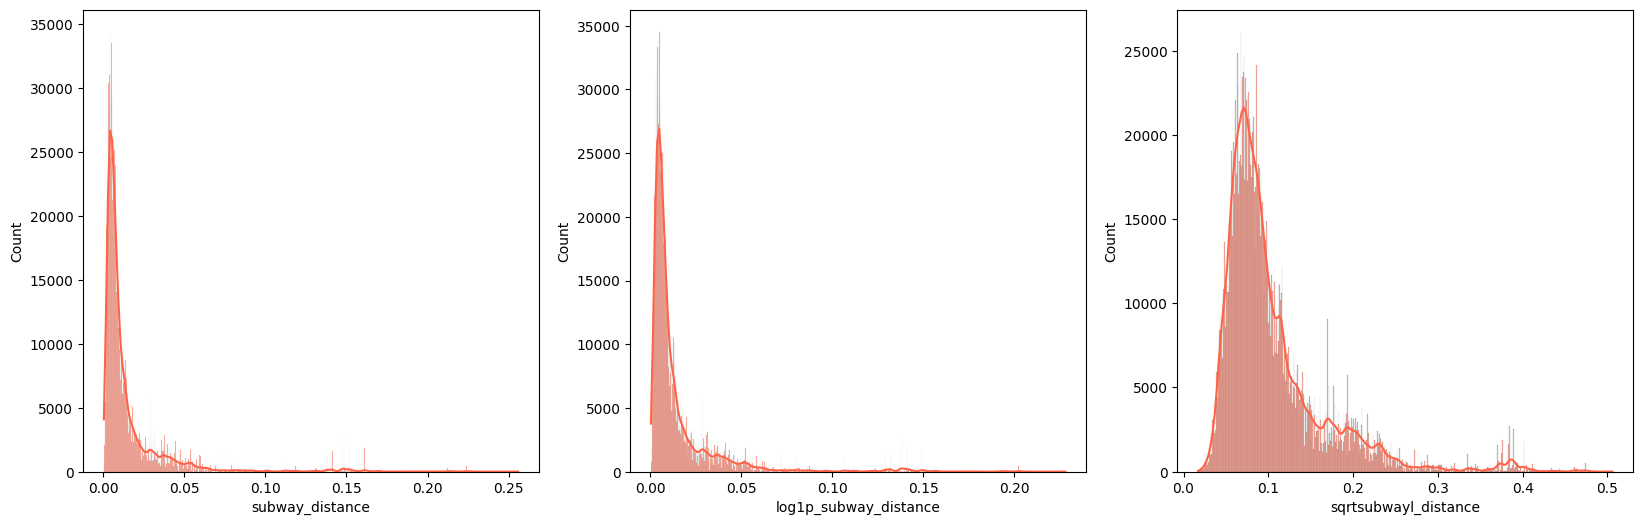

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(data=train_data, x="subway_distance", color="tomato", kde=True, ax=axs[0])
log1p_school = np.log1p(train_data["subway_distance"])
sns.histplot(data=log1p_school, color="tomato", kde=True, ax=axs[1])
axs[1].set_xlabel("log1p_subway_distance")
sqrt_school = np.sqrt(train_data["subway_distance"])
sns.histplot(data=sqrt_school, color="tomato", kde=True, ax=axs[2])
axs[2].set_xlabel("sqrtsubwayl_distance")

plt.show()

### 금리 분포

<Axes: xlabel='interest_rate', ylabel='Count'>

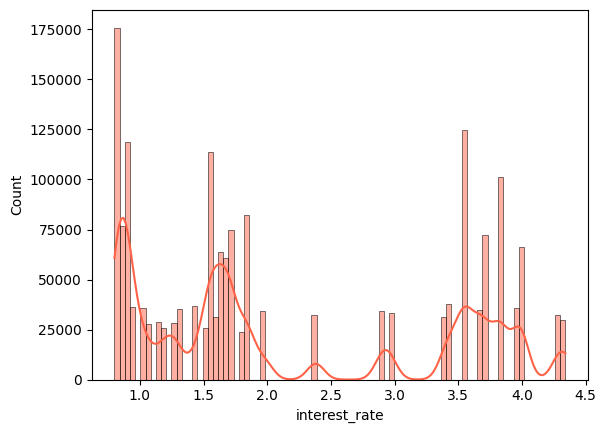

In [22]:
sns.histplot(data=train_data, x="interest_rate", color="tomato", kde=True)

### Histplot 정리

- 계약 시점은 연도 정도가 쓸만하지 않을까싶네

- 면적은 특정 구간의 비율이 매우 크다는 점 외에 특징은 없어 보인다.

- 층수는 로그변환이 괜찮아보이는데, 잘은 모르겠다.

- 2024년은 삭제해도 될 정도의 개수인듯.

- 두 피처의 선형결합이라 뺄까 하고 있었는데, 특징적인 것도 없어 보여서 빼는 것이 맞는 것 같다.

- deposit은 로그변환해서 예측한 뒤 역변환하는 것이 좋아보인다.

- 최단거리 변수는 제곱근 변환으로 스케일링하면 딱일듯?


## Boxplot

In [18]:
colors = cm.viridis(np.linspace(0, 1, 15))
fig, axs = plt.subplots(1, 15, figsize= (20, 5))

for i, feature in enumerate(train_data):
    sns.boxplot(data=train_data, y=feature, color=colors[i], ax=axs[i])
    axs[i].set_title(feature, fontsize=8)
    axs[i].set_ylabel("")
    axs[i].set_yticks([])
    axs[i].set_yticklabels("")
    axs[i].set_xticks([])

plt.show()

NameError: name 'cm' is not defined

# Feature Engineering

In [9]:
# 이상치 탐지
def find_outliers_iqr(data: pd.Series) -> pd.Series:
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

In [19]:
from sklearn.model_selection import train_test_split

def preprocessing(X: pd.DataFrame, y: pd.Series, train: bool) -> tuple[pd.DataFrame, pd.Series]:
    # 필요없는 피처 삭제
    X = X.drop(["contract_month", "contract_day", "age"], axis=1)

    # 스케일링
    X[["school_distance", "park_distance", "subway_distance"]] = np.sqrt(X[["school_distance", "park_distance", "subway_distance"]])
    if train: y = np.log1p(y)

    # 이상치 제거
    if train:
        deposit_outliers_index = find_outliers_iqr(y).index
        X = X.drop(deposit_outliers_index, axis=0)
        y = y.drop(deposit_outliers_index)
        built_year_outliers_index = X[X["built_year"] >= 2024].index
        X = X.drop(built_year_outliers_index, axis=0)
        y = y.drop(built_year_outliers_index)
    
    return X, y

X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop("deposit", axis=1), train_data["deposit"], test_size=0.2, random_state=42)
X_train, y_train = preprocessing(X_train, y_train, train=True)
X_valid, y_valid = preprocessing(X_valid, y_valid, train=False)

In [20]:
y_valid

1579471   34000.00
1585586   15600.00
460878    19000.00
89474     44000.00
137158    41000.00
            ...   
239477    28000.00
1188167   99750.00
414827    59000.00
1728262   22000.00
834107    29000.00
Name: deposit, Length: 360246, dtype: float64

# Linear Regression (vanilla)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_valid)

mae_lr = mean_absolute_error(y_valid, np.expm1(y_pred))
print(mae_lr)

9561.204853939498


In [86]:
test_fillna = test_data.fillna(method="ffill")

In [87]:
# Vanila lr output
output = lr_model.predict(test_fillna)
submission_df["deposit"] = output
submission_df.to_csv("output.csv", index=False)

## Polynomial
- latitude나 longitude와 같은 변수는 1차보다는 2차항으로 만드는 것이 더 좋을 것이라고 생각해 적용해봄.

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso

# 세 모델에 대해 이차항 생성과 모델 생성을 하나의 파이프라인으로 연결
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_Ridge = make_pipeline(PolynomialFeatures(degree=2), Ridge(random_state=42))
poly_Lasso = make_pipeline(PolynomialFeatures(degree=2), Lasso(random_state=42))

# 모델 훈련
poly_model.fit(X_train, y_train)
poly_Ridge.fit(X_train, y_train)
poly_Lasso.fit(X_train, y_train)

# 예측
y_pred_poly = poly_model.predict(X_valid)
y_pred_poly_Ridge = poly_Ridge.predict(X_valid)
y_pred_poly_Lasso = poly_Lasso.predict(X_valid)

# 평가
mae_poly = mean_absolute_error(y_valid, y_pred_poly)
mae_poly_Ridge = mean_absolute_error(y_valid, y_pred_poly_Ridge)
mae_poly_Lasso = mean_absolute_error(y_valid, y_pred_poly_Lasso)

# MAE 출력
print("#### Polynomial MAE ####")
print(f"linear: {mae_poly}")
print(f"Ridge: {mae_poly_Ridge}")
print(f"Lasso: {mae_poly_Lasso}")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.710e+14, tolerance: 9.790e+10
  model = cd_fast.enet_coordinate_descent(


#### Polynomial MAE ####
linear: 10980.894611589189
Ridge: 11212.06640731914
Lasso: 12673.969710311347


In [88]:
# Polynomial lr output
output = poly_model.predict(test_fillna)
submission_df["deposit"] = output
submission_df.to_csv("output.csv", index=False)

원하는 변수만 2차항 생성

In [68]:
# poly = PolynomialFeatures(2, include_bias=False)
# train_poly = poly.fit_transform(train_data[['latitude', 'longitude']])

# # 변환된 다항식 항목을 데이터프레임으로 변환
# train_poly_df = pd.DataFrame(train_poly, columns=poly.get_feature_names_out(['latitude', 'longitude']))
# train_poly_df = pd.concat([train_poly_df, train_data], axis=1)
# X_train_poly, X_valid_poly, y_train_poly, y_valid_poly = train_test_split(train_poly_df.drop(["deposit"], axis=1), train_poly_df["deposit"], test_size=0.2, random_state=42)

# lr_model.fit(X_train_poly, y_train_poly)
# y_pred_poly2 = lr_model.predict(X_valid_poly)
# mae_poly2 = mean_absolute_error(y_valid_poly, y_pred_poly2)
# print(mae_poly2)

-> linear regression은 좀 별로인듯?

# CatBoost

In [23]:
from catboost import CatBoostRegressor
import optuna
import warnings
warnings.filterwarnings("ignore")

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.5),
        "depth": trial.suggest_int("depth", 4, 15),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_loguniform("bagging_temperature", 0.01, 1),
        "border_count": trial.suggest_int("border_count", 32, 256),
        "cat_features": ["contract_year",
                        #  "contract_month",
                        #  "contract_day",
                         "contract_type"],
        "task_type": "GPU",
        "devices": "0",
        "verbose": 0
    }

    cb_model = CatBoostRegressor(**params)
    cb_model.fit(X_train, y_train)
    y_pred_cb = cb_model.predict(X_valid)
    mae_cb = mean_absolute_error(y_valid, np.expm1(y_pred_cb))
    return mae_cb

# Optuna 스터디 생성
study = optuna.create_study(direction="minimize")  # MAE를 최소화하는 방향으로 설정

# 최적화 수행
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-10-04 14:40:13,787] A new study created in memory with name: no-name-314b1bba-4db5-4986-a4d9-84d1be737201
[I 2024-10-04 14:40:28,332] Trial 0 finished with value: 6595.396746032156 and parameters: {'iterations': 330, 'learning_rate': 0.024749984428211615, 'depth': 8, 'l2_leaf_reg': 10, 'bagging_temperature': 0.4315318485123294, 'border_count': 224}. Best is trial 0 with value: 6595.396746032156.
[I 2024-10-04 14:41:30,653] Trial 1 finished with value: 4281.837909228132 and parameters: {'iterations': 528, 'learning_rate': 0.4025313124151185, 'depth': 13, 'l2_leaf_reg': 2, 'bagging_temperature': 0.16524917093165226, 'border_count': 37}. Best is trial 1 with value: 4281.837909228132.
[I 2024-10-04 14:41:48,492] Trial 2 finished with value: 4832.576994654823 and parameters: {'iterations': 483, 'learning_rate': 0.25808929076536313, 'depth': 7, 'l2_leaf_reg': 9, 'bagging_temperature': 0.208342929646876, 'border_count': 208}. Best is trial 1 with value: 4281.837909228132.
[I 2024-10-0

Best trial:
  Value: 4142.580398712751
  Params:
    iterations: 854
    learning_rate: 0.1917198413663799
    depth: 15
    l2_leaf_reg: 4
    bagging_temperature: 0.11953914991801935
    border_count: 252


## CatBoost output

In [24]:
best_params = study.best_params
cat_model = CatBoostRegressor(**best_params)
cat_model.fit(train_data.drop("deposit", axis=1), train_data["deposit"])
output = cat_model.predict(test_data)
submission_df["deposit"] = output
submission_df.to_csv("output.csv", index=False)

0:	learn: 22459.9218573	total: 617ms	remaining: 8m 46s
1:	learn: 19628.2318069	total: 1.24s	remaining: 8m 49s
2:	learn: 17395.7659032	total: 1.87s	remaining: 8m 51s
3:	learn: 15627.8051502	total: 2.52s	remaining: 8m 54s
4:	learn: 14211.2315714	total: 3.13s	remaining: 8m 52s
5:	learn: 13106.5625750	total: 3.77s	remaining: 8m 53s
6:	learn: 12278.1412932	total: 4.37s	remaining: 8m 48s
7:	learn: 11650.0205152	total: 4.98s	remaining: 8m 46s
8:	learn: 11118.3922503	total: 5.59s	remaining: 8m 44s
9:	learn: 10677.6968279	total: 6.2s	remaining: 8m 43s
10:	learn: 10338.0848207	total: 6.83s	remaining: 8m 43s
11:	learn: 10089.8450661	total: 7.44s	remaining: 8m 42s
12:	learn: 9845.5305447	total: 8.07s	remaining: 8m 42s
13:	learn: 9676.4864174	total: 8.67s	remaining: 8m 40s
14:	learn: 9478.6055363	total: 9.29s	remaining: 8m 39s
15:	learn: 9311.0950693	total: 9.89s	remaining: 8m 37s
16:	learn: 9195.1619434	total: 10.5s	remaining: 8m 37s
17:	learn: 9104.9097586	total: 11.1s	remaining: 8m 35s
18:	learn

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:72: Feature distance_km is present in model but not in pool.